In [3]:
#All required imports
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.optimize import minimize_scalar
import sys
import os
import random
from timeit import default_timer
import time
from matplotlib import pyplot as plt

In [40]:


ts = default_timer()
time.sleep(2.4)
te = default_timer()
print((te-ts))

2.4148651999998947


In [4]:
#class 
class Graph(object):
    @staticmethod
    def preparation(path):
        cpy = "copy.txt"
        cpy = "modified_" + os.path.split(path)[-1]

        with open(path) as file, open(cpy, "w") as copy:
            # read header
            file.__next__()
            file.__next__()
            arr = file.__next__().split(" ")
            nodes, edges = arr[2], arr[4]
            #print(nodes, edges)
            file.__next__()
            copy.write(nodes + " " + edges)
            # copy main part

            lst = np.zeros(int(nodes))

            try:
                cnt = 1
                s = file.__next__()
                strings_to_write = [s.replace("\n", "")]
                src = s.split("\t")[0]

                while True:
                    s = file.__next__()
                    curr_src = s.split("\t")[0]

                    if curr_src == src:

                        cnt += 1
                        strings_to_write.append(s.replace("\n", ""))

                    else:

                        output = "".join(
                            ["".join(["\t", str(1 / cnt), "\n"]).join(strings_to_write), "\t", str(1 / cnt), "\n"])
                        copy.write(output)
                        strings_to_write = [s.replace("\n", "")]
                        
                        lst[int(src)] = 1
                        
                        src = s.split("\t")[0]
                        cnt = 1
            except StopIteration:
                pass
            # create "Google.com"
            for i in range(int(nodes)):
                if lst[i] == 0:
                    copy.write(str(i) + "\t" + "0" + "\t" + "1" + "\n")
                    
                    
    @staticmethod
    def preparation_stanford(path):
        cpy = "copy.txt"
        cpy = "modified_" + os.path.split(path)[-1]

        with open(path) as file, open(cpy, "w") as copy:
            # read header
            file.__next__()
            file.__next__()
            arr = file.__next__().split(" ")
            nodes, edges = arr[2], arr[4]
            #print(nodes, edges)
            file.__next__()
            copy.write(nodes + " " + edges)
            # copy main part

            lst = np.zeros(int(nodes))

            try:
                cnt = 1
                s = file.__next__()

                nd = s.replace("\n", "").split("\t")
                nd[0] = str(int(nd[0]) - 1)
                nd[1] = str(int(nd[1]) - 1)
                strings_to_write = ["\t".join(nd)]
                src = s.split("\t")[0]

                while True:
                    s = file.__next__()
                    curr_src = s.split("\t")[0]

                    if curr_src == src:

                        nd = s.split("\t")
                        nd[0] = str(int(nd[0]) - 1)
                        nd[1] = str(int(nd[1]) - 1)
                        if (int(nd[0]) > int(nodes)):
                            print(nd[0])
                        if (int(nd[1]) > int(nodes)):
                            print(nd[1])
                        s= "\t".join(nd)
                        cnt += 1
                        strings_to_write.append(s.replace("\n", ""))

                    else:

                        output = "".join(
                            ["".join(["\t", str(1 / cnt), "\n"]).join(strings_to_write), "\t", str(1 / cnt), "\n"])
                        copy.write(output)

                        nd = s.replace("\n", "").split("\t")
                        nd[0] = str(int(nd[0]) - 1)
                        nd[1] = str(int(nd[1]) - 1)
                        strings_to_write = ["\t".join(nd)]

                        lst[int(src) - 1] = 1
                        src = s.split("\t")[0]
                        cnt = 1
            except StopIteration:
                pass
            # create "Google.com"
            for i in range(int(nodes)):
                if lst[i] == 0:
                    copy.write(str(i) + "\t" + "0" + "\t" + "1" + "\n")

    def __init__(self, path: str):
        cpy = "copy.txt"
        with open(path) as file, open(cpy, "w") as copy:
            arr = file.__next__().split(" ")
            nodes, edges = int(arr[0]), int(arr[1].replace("\n", ""))
            try:
                while True:
                    copy.write(file.__next__())
            except StopIteration:
                pass

        arcgraph = pd.read_csv(cpy, header=None, names=["i", "j", "weight"], sep="\t")

        self.web_matr = csr_matrix((arcgraph["weight"], (arcgraph["i"], arcgraph["j"])),
                                   shape=(nodes, nodes)).transpose().tocsc()

        self.size = nodes

        os.remove(cpy)

In [110]:
#prepare files
#Graph.preparation("web-NotreDame.txt")
#Graph.preparation_stanford("web-Stanford.txt")
#Graph.preparation_stanford("web-BerkStan.txt")
Graph.preparation_stanford("web-Google.txt")

In [109]:
#Graph.preparation_stanford("CA-AstroPh.txt")
#Graph.preparation_stanford("CA-GrQc.txt") 
#Graph.preparation_stanford("CA-CondMat.txt")

In [5]:
def MSI(graph: Graph, accuracy):
    indexes = [i for i in range(graph.size)]

    teleport_coefficient = 0.15

    matrix = graph.web_matr * (1 - teleport_coefficient) + \
             csr_matrix((np.ones(graph.size), (indexes, indexes)),
                        shape=(graph.size, graph.size)) * teleport_coefficient

    iteration_number = 0

    current_vec = np.ones(graph.size) / graph.size

    tp_vec = np.ones(graph.size) / graph.size

    prev_vec = current_vec

    while True:

        iteration_number += 1

        current_vec = matrix.dot(prev_vec)

        if (np.linalg.norm(current_vec - prev_vec) < accuracy):
            return current_vec, iteration_number

        prev_vec = current_vec

In [6]:
def Polyak_Tremba(graph: Graph, accuracy):
    indexes = [i for i in range(graph.size)]

    teleport_coefficient = 0.15

    matrix = graph.web_matr * (1 - teleport_coefficient) + \
             csr_matrix((np.ones(graph.size), (indexes, indexes)),
                        shape=(graph.size, graph.size)) * teleport_coefficient

    iteration_number = 0

    current_vec = np.ones(graph.size) / graph.size

    prev_vec = current_vec
    cumulative_sum_vec = np.zeros(graph.size)

    while True:
        iteration_number += 1

        current_vec = matrix.dot(prev_vec)
        cumulative_sum_vec += current_vec

        control_vec = cumulative_sum_vec / iteration_number
        if np.linalg.norm(matrix.dot(control_vec) - control_vec, ord=1) < accuracy:
            return control_vec, iteration_number

        prev_vec = current_vec

In [7]:
def FrankWolf(graph: Graph, accuracy):
    # print("Frank-Wolf")
    indexes = np.array([i for i in range(graph.size)])
    operator = graph.web_matr - csr_matrix((np.ones(graph.size), (indexes, indexes)),
                                           shape=(graph.size, graph.size))

    func = lambda x: sum(map(lambda t: t ** 2, operator.dot(x))) * 0.5

    x_cur = np.ones(graph.size) / graph.size
    iteration_num = 0

    while True:
        iteration_num += 1

        y = np.zeros(graph.size)
        y[x_cur.argmin()] = 1

        x_prev = x_cur
        gamma = 2 / (iteration_num + 1)
        x_cur = (1 - gamma) * x_cur + gamma * y
        if abs(func(x_cur) - func(x_prev)) < accuracy:
            return x_cur, iteration_num

In [8]:
def MonteCarlo(graph: Graph,  iterations=1000):
    matrix = graph.web_matr

    current_node = random.randint(0, graph.size - 1)

    iteration_num = 0
    vec = np.zeros(graph.size)

    for i in range(iterations):
        selection = np.array(matrix.getcol(current_node).nonzero()[0])
        rand = random.randint(0, len(selection) - 1)
        current_node = selection[rand]
        vec[current_node] += 1

        iteration_num += 1

    return vec / iteration_num

In [9]:
#NotreDameWebGraph
graph = Graph("modified_web-NotreDame.txt")


MSI_resultsND = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsND = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsND = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsND = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsND["Iterations"].append(MSI_it)
    MSI_resultsND["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsND["Accuracy"].append(i)
    MSI_resultsND["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsND["Iterations"].append(PT_it)
    PT_resultsND["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsND["Accuracy"].append(i)
    PT_resultsND["Exec_time"].append(te - ts)

for i in range(1, 7):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsND["Iterations"].append(FW_it)
    FW_resultsND["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsND["Accuracy"].append(i)
    FW_resultsND["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsND["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsND["Iterations"].append(iterations)
    MC_resultsND["Exec_time"].append(te - ts)
    iterations *= 10
    

In [10]:
#StanfordWebGraph
graph = Graph("modified_web-Stanford.txt")


MSI_results_Stanf = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_results_Stanf = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_results_Stanf = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_results_Stanf = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_results_Stanf["Iterations"].append(MSI_it)
    MSI_results_Stanf["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_results_Stanf["Accuracy"].append(i)
    MSI_results_Stanf["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_results_Stanf["Iterations"].append(PT_it)
    PT_results_Stanf["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_results_Stanf["Accuracy"].append(i)
    PT_results_Stanf["Exec_time"].append(te - ts)

for i in range(1, 7):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_results_Stanf["Iterations"].append(FW_it)
    FW_results_Stanf["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_results_Stanf["Accuracy"].append(i)
    FW_results_Stanf["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_results_Stanf["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_results_Stanf["Iterations"].append(iterations)
    MC_results_Stanf["Exec_time"].append(te - ts)
    iterations *= 10

In [11]:
#StanfordWebGraph
graph = Graph("modified_web-BerkStan.txt")


MSI_resultsBerkStan = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsBerkStan = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsBerkStan = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsBerkStan = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsBerkStan["Iterations"].append(MSI_it)
    MSI_resultsBerkStan["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsBerkStan["Accuracy"].append(i)
    MSI_resultsBerkStan["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsBerkStan["Iterations"].append(PT_it)
    PT_resultsBerkStan["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsBerkStan["Accuracy"].append(i)
    PT_resultsBerkStan["Exec_time"].append(te - ts)

for i in range(1, 7):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsBerkStan["Iterations"].append(FW_it)
    FW_resultsBerkStan["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsBerkStan["Accuracy"].append(i)
    FW_resultsBerkStan["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsBerkStan["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsBerkStan["Iterations"].append(iterations)
    MC_resultsBerkStan["Exec_time"].append(te - ts)
    iterations *= 10

In [13]:
#StanfordWebGraph
graph = Graph("modified_web-Google.txt")


MSI_resultsGoogle = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsGoogle = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsGoogle = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsGoogle = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsGoogle["Iterations"].append(MSI_it)
    MSI_resultsGoogle["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsGoogle["Accuracy"].append(i)
    MSI_resultsGoogle["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsGoogle["Iterations"].append(PT_it)
    PT_resultsGoogle["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsGoogle["Accuracy"].append(i)
    PT_resultsGoogle["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsGoogle["Iterations"].append(FW_it)
    FW_resultsGoogle["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsGoogle["Accuracy"].append(i)
    FW_resultsGoogle["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsGoogle["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsGoogle["Iterations"].append(iterations)
    MC_resultsGoogle["Exec_time"].append(te - ts)
    iterations *= 10

KeyboardInterrupt: 

In [25]:

#StanfordWebGraph
graph = Graph("modified_CA-AstroPh.txt")


MSI_resultsCA_AstroPh = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsCA_AstroPh = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsCA_AstroPh = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsCA_AstroPh = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsCA_AstroPh["Iterations"].append(MSI_it)
    MSI_resultsCA_AstroPh["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsCA_AstroPh["Accuracy"].append(i)
    MSI_resultsCA_AstroPh["Exec_time"].append(te - ts)

for i in range(1, 6):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsCA_AstroPh["Iterations"].append(PT_it)
    PT_resultsCA_AstroPh["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsCA_AstroPh["Accuracy"].append(i)
    PT_resultsCA_AstroPh["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsCA_AstroPh["Iterations"].append(FW_it)
    FW_resultsCA_AstroPh["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsCA_AstroPh["Accuracy"].append(i)
    FW_resultsCA_AstroPh["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsCA_AstroPh["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsCA_AstroPh["Iterations"].append(iterations)
    MC_resultsCA_AstroPh["Exec_time"].append(te - ts)
    iterations *= 10

In [18]:
#StanfordWebGraph
graph = Graph("modified_CA-GrQc.txt")


MSI_resultsCA_GrQc = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsCA_GrQc = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsCA_GrQc = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsCA_GrQc = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsCA_GrQc["Iterations"].append(MSI_it)
    MSI_resultsCA_GrQc["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsCA_GrQc["Accuracy"].append(i)
    MSI_resultsCA_GrQc["Exec_time"].append(te - ts)

for i in range(1, 6):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsCA_GrQc["Iterations"].append(PT_it)
    PT_resultsCA_GrQc["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsCA_GrQc["Accuracy"].append(i)
    PT_resultsCA_GrQc["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsCA_GrQc["Iterations"].append(FW_it)
    FW_resultsCA_GrQc["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsCA_GrQc["Accuracy"].append(i)
    FW_resultsCA_GrQc["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsCA_GrQc["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsCA_GrQc["Iterations"].append(iterations)
    MC_resultsCA_GrQc["Exec_time"].append(te - ts)
    iterations *= 10

In [31]:
#StanfordWebGraph
graph = Graph("modified_CA-CondMat.txt")


MSI_resultsCA_CondMat = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
PT_resultsCA_CondMat = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
FW_resultsCA_CondMat = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}
MC_resultsCA_CondMat = {"Iterations" : [], "Accuracy" : [],  "Norm_diff" : [], "Exec_time" : []}


for i in range(1, 7):
    accuracy = 10 ** (-i)
    
    ts = default_timer()
   
    MSI_vec, MSI_it = MSI(graph, accuracy)#7
    te = default_timer()
    MSI_resultsCA_CondMat["Iterations"].append(MSI_it)
    MSI_resultsCA_CondMat["Norm_diff"].append(np.linalg.norm(MSI_vec - graph.web_matr.dot(MSI_vec)))
    MSI_resultsCA_CondMat["Accuracy"].append(i)
    MSI_resultsCA_CondMat["Exec_time"].append(te - ts)

for i in range(1, 6):
    accuracy = 10 ** (-i)
    ts = default_timer()
   
    PT_vec,  PT_it= Polyak_Tremba(graph, accuracy)#5
    te = default_timer()
    PT_resultsCA_CondMat["Iterations"].append(PT_it)
    PT_resultsCA_CondMat["Norm_diff"].append(np.linalg.norm(PT_vec - graph.web_matr.dot(PT_vec)))
    PT_resultsCA_CondMat["Accuracy"].append(i)
    PT_resultsCA_CondMat["Exec_time"].append(te - ts)

for i in range(1, 5):
    accuracy = 10 ** (-i)
    ts = default_timer()
    FW_vec, FW_it = FrankWolf(graph, accuracy)#5
    te = default_timer()
    FW_resultsCA_CondMat["Iterations"].append(FW_it)
    FW_resultsCA_CondMat["Norm_diff"].append(np.linalg.norm(FW_vec - graph.web_matr.dot(FW_vec)))
    FW_resultsCA_CondMat["Accuracy"].append(i)
    FW_resultsCA_CondMat["Exec_time"].append(te - ts)
iterations = 100
while True:
    if iterations > 100000:
        break
    ts = default_timer()
    MC_vec = MonteCarlo(graph, iterations)
    te = default_timer()
    MC_resultsCA_CondMat["Norm_diff"].append(np.linalg.norm(MC_vec - graph.web_matr.dot(MC_vec)))
    MC_resultsCA_CondMat["Iterations"].append(iterations)
    MC_resultsCA_CondMat["Exec_time"].append(te - ts)
    iterations *= 10

KeyboardInterrupt: 

In [48]:
#print(MSI_resultsND)
#print(PT_resultsND)
#print(FW_resultsND)
#print(MC_resultsND)
#print(MSI_results_Stanf)
#print(PT_results_Stanf)
#print(FW_results_Stanf)
#print(MC_results_Stanf)
#print(MSI_resultsCA_AstroPh)
#print(PT_resultsCA_AstroPh)
#print(FW_resultsCA_AstroPh)
#print(MC_resultsCA_AstroPh)
#print(MSI_resultsBerkStan)
#print(PT_resultsBerkStan)
#print(FW_resultsBerkStan)
#print(MC_resultsBerkStan)
#print(MSI_resultsCA_GrQc)
#print(PT_resultsCA_GrQc)
#print(FW_resultsCA_GrQc)
#print(MC_resultsCA_GrQc)
#print(MSI_resultsGoogle) 
#print(PT_resultsGoogle) 
#print(FW_resultsGoogle) 
#print(MC_resultsGoogle)

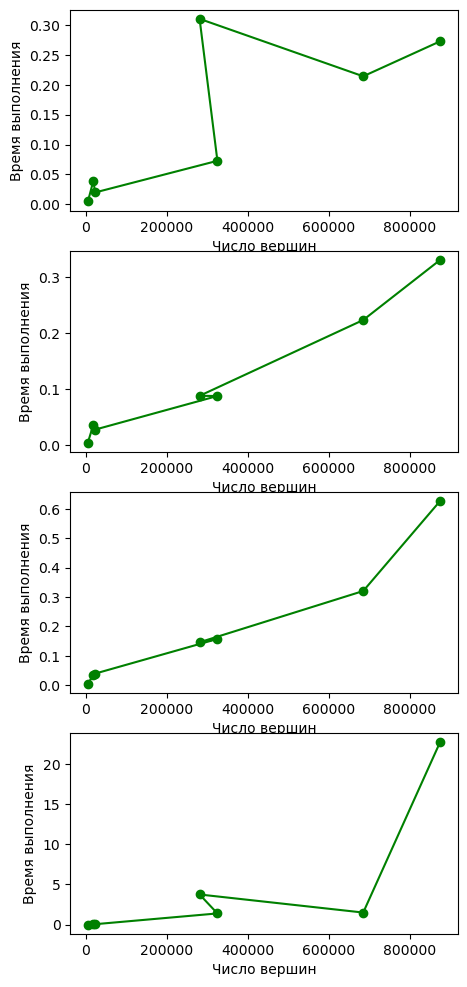

In [56]:
node_number = [5200, 18700, 23100, 325000, 281000, 685000, 875000]
MSI_time_acc_1 = [MSI_resultsCA_GrQc["Exec_time"][0],
                  MSI_resultsCA_AstroPh["Exec_time"][0],
                  MSI_resultsCA_CondMat["Exec_time"][0],
                  MSI_results_Stanf["Exec_time"][0],
                  MSI_resultsND["Exec_time"][0],
                   MSI_resultsBerkStan["Exec_time"][0],
                   MSI_resultsGoogle["Exec_time"][0],
                  ]
MSI_time_acc_2 = [MSI_resultsCA_GrQc["Exec_time"][1],
                  MSI_resultsCA_AstroPh["Exec_time"][1],
                  MSI_resultsCA_CondMat["Exec_time"][1],
                  MSI_results_Stanf["Exec_time"][1],
                  MSI_resultsND["Exec_time"][1],
                   MSI_resultsBerkStan["Exec_time"][1],
                   MSI_resultsGoogle["Exec_time"][1],
                  ]
MSI_time_acc_3 = [MSI_resultsCA_GrQc["Exec_time"][2],
                  MSI_resultsCA_AstroPh["Exec_time"][2],
                  MSI_resultsCA_CondMat["Exec_time"][2],
                  MSI_results_Stanf["Exec_time"][2],
                  MSI_resultsND["Exec_time"][2],
                   MSI_resultsBerkStan["Exec_time"][2],
                   MSI_resultsGoogle["Exec_time"][2],
                  ]
MSI_time_acc_4 = [MSI_resultsCA_GrQc["Exec_time"][3],
                  MSI_resultsCA_AstroPh["Exec_time"][3],
                  MSI_resultsCA_CondMat["Exec_time"][3],
                  MSI_results_Stanf["Exec_time"][3],
                  MSI_resultsND["Exec_time"][3],
                   MSI_resultsBerkStan["Exec_time"][3],
                   MSI_resultsGoogle["Exec_time"][3],
                  ]
fig, axes = plt.subplots(4, 1, figsize = (5,12))
[axes[i].set_xlabel("Число вершин") for i in range(4) ]
[axes[i].set_ylabel("Время выполнения") for i in range(4) ]

axes[0].plot(node_number, MSI_time_acc_1,  "go",linestyle='-')
axes[1].plot(node_number, MSI_time_acc_2, "go",linestyle='-')
axes[2].plot(node_number, MSI_time_acc_3, "go",linestyle='-')
axes[3].plot(node_number, MSI_time_acc_4, "go",linestyle='-')

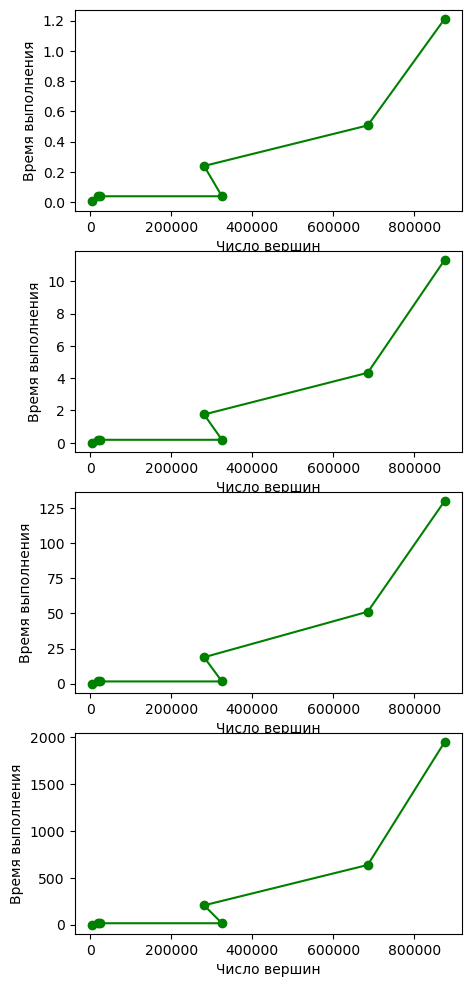

In [63]:
node_number = [5200, 18700, 23100, 325000, 281000, 685000, 875000]
PT_time_acc_1 = [PT_resultsCA_GrQc["Exec_time"][0],
                  PT_resultsCA_AstroPh["Exec_time"][0],
                  PT_resultsCA_AstroPh["Exec_time"][0],
                  PT_resultsCA_AstroPh["Exec_time"][0],
                  PT_resultsND["Exec_time"][0],
                   PT_resultsBerkStan["Exec_time"][0],
                PT_resultsGoogle["Exec_time"][0],
                  ]
PT_time_acc_2 = [PT_resultsCA_GrQc["Exec_time"][1],
                  PT_resultsCA_AstroPh["Exec_time"][1],
                  PT_resultsCA_AstroPh["Exec_time"][1],
                  PT_resultsCA_AstroPh["Exec_time"][1],
                  PT_resultsND["Exec_time"][1],
                   PT_resultsBerkStan["Exec_time"][1],
                   PT_resultsGoogle["Exec_time"][1],
                  ]
PT_time_acc_3 = [PT_resultsCA_GrQc["Exec_time"][2],
                  PT_resultsCA_AstroPh["Exec_time"][2],
                  PT_resultsCA_AstroPh["Exec_time"][2],
                  PT_resultsCA_AstroPh["Exec_time"][2],
                  PT_resultsND["Exec_time"][2],
                   PT_resultsBerkStan["Exec_time"][2],
                   PT_resultsGoogle["Exec_time"][2],
                  ]
PT_time_acc_4 = [PT_resultsCA_GrQc["Exec_time"][3],
                  PT_resultsCA_AstroPh["Exec_time"][3],
                  PT_resultsCA_AstroPh["Exec_time"][3],
                  PT_resultsCA_AstroPh["Exec_time"][3],
                  PT_resultsND["Exec_time"][3],
                   PT_resultsBerkStan["Exec_time"][3],
                   PT_resultsGoogle["Exec_time"][3],
                  ]
fig, axes = plt.subplots(4, 1, figsize = (5,12))
[axes[i].set_xlabel("Число вершин") for i in range(4) ]
[axes[i].set_ylabel("Время выполнения") for i in range(4) ]

axes[0].plot(node_number, PT_time_acc_1,   "go",linestyle='-')
axes[1].plot(node_number, PT_time_acc_2,   "go",linestyle='-')
axes[2].plot(node_number, PT_time_acc_3,   "go",linestyle='-')
axes[3].plot(node_number, PT_time_acc_4,  "go",linestyle='-')

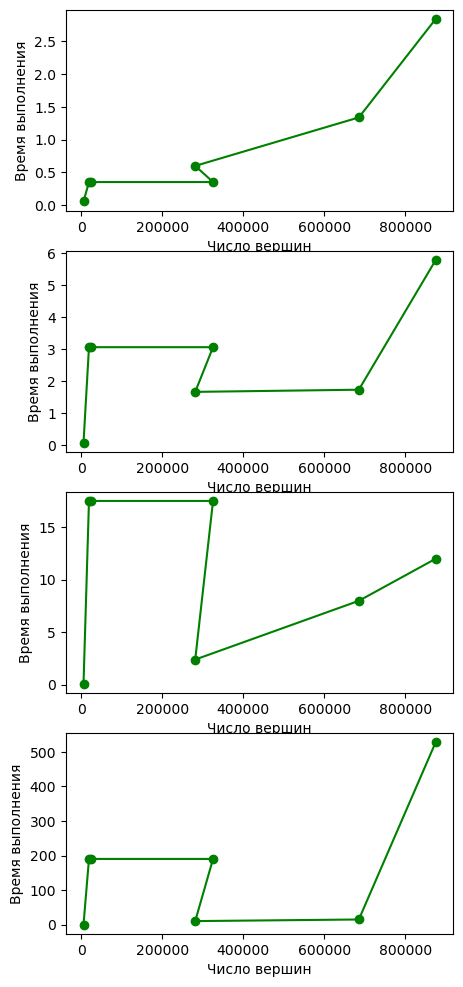

In [66]:
node_number = [5200, 18700, 23100, 325000, 281000, 685000, 875000]
FW_time_acc_1 = [FW_resultsCA_GrQc["Exec_time"][0],
                  FW_resultsCA_AstroPh["Exec_time"][0],
                  FW_resultsCA_AstroPh["Exec_time"][0],
                  FW_resultsCA_AstroPh["Exec_time"][0],
                  FW_resultsND["Exec_time"][0],
                   FW_resultsBerkStan["Exec_time"][0],
                FW_resultsGoogle["Exec_time"][0],
                  ]
FW_time_acc_2 = [FW_resultsCA_GrQc["Exec_time"][1],
                  FW_resultsCA_AstroPh["Exec_time"][1],
                  FW_resultsCA_AstroPh["Exec_time"][1],
                  FW_resultsCA_AstroPh["Exec_time"][1],
                  FW_resultsND["Exec_time"][1],
                   FW_resultsBerkStan["Exec_time"][1],
                   FW_resultsGoogle["Exec_time"][1],
                  ]
FW_time_acc_3 = [FW_resultsCA_GrQc["Exec_time"][2],
                  FW_resultsCA_AstroPh["Exec_time"][2],
                  FW_resultsCA_AstroPh["Exec_time"][2],
                  FW_resultsCA_AstroPh["Exec_time"][2],
                  FW_resultsND["Exec_time"][2],
                   FW_resultsBerkStan["Exec_time"][2],
                   FW_resultsGoogle["Exec_time"][2],
                  ]
FW_time_acc_4 = [FW_resultsCA_GrQc["Exec_time"][3],
                  FW_resultsCA_AstroPh["Exec_time"][3],
                  FW_resultsCA_AstroPh["Exec_time"][3],
                  FW_resultsCA_AstroPh["Exec_time"][3],
                  FW_resultsND["Exec_time"][3],
                   FW_resultsBerkStan["Exec_time"][3],
                   FW_resultsGoogle["Exec_time"][3],
                  ]
fig, axes = plt.subplots(4, 1, figsize = (5,12))
[axes[i].set_xlabel("Число вершин") for i in range(4) ]
[axes[i].set_ylabel("Время выполнения") for i in range(4) ]

axes[0].plot(node_number, FW_time_acc_1,   "go",linestyle='-')
axes[1].plot(node_number, FW_time_acc_2,   "go",linestyle='-')
axes[2].plot(node_number, FW_time_acc_3,   "go",linestyle='-')
axes[3].plot(node_number, FW_time_acc_4,  "go",linestyle='-')

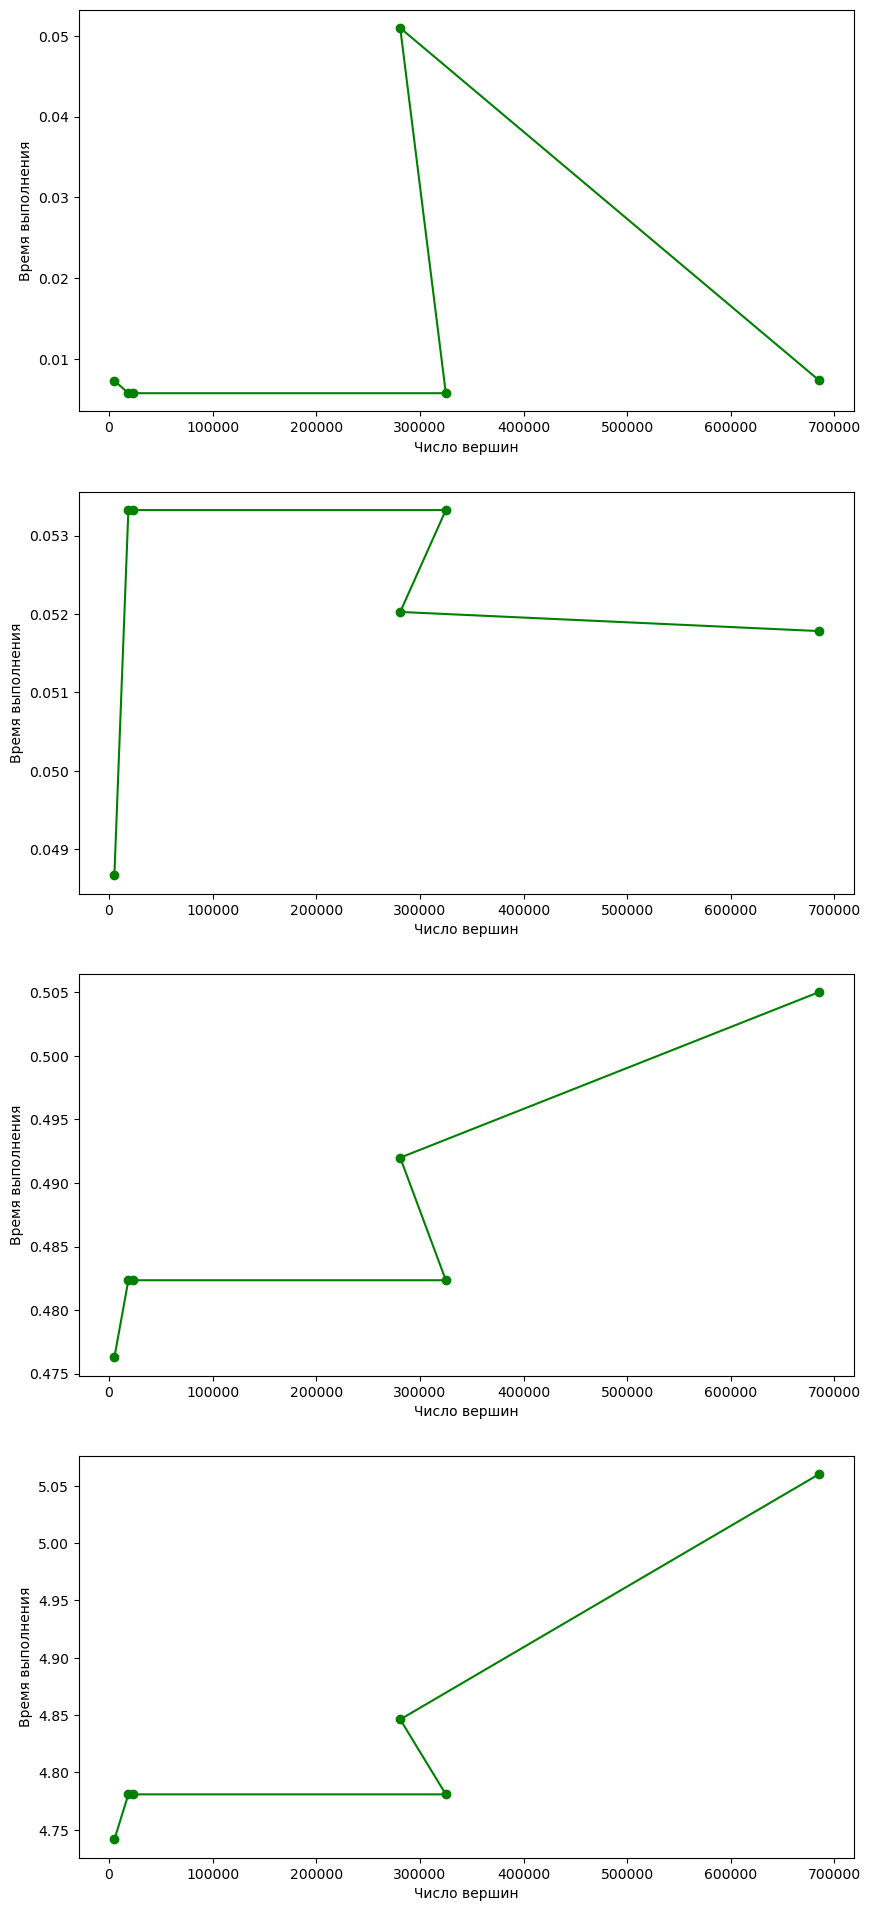

In [68]:
node_number = [5200, 18700, 23100, 325000, 281000, 685000]
MC_time_acc_1 = [MC_resultsCA_GrQc["Exec_time"][0],
                  MC_resultsCA_AstroPh["Exec_time"][0],
                  MC_resultsCA_AstroPh["Exec_time"][0],
                  MC_resultsCA_AstroPh["Exec_time"][0],
                  MC_resultsND["Exec_time"][0],
                   MC_resultsBerkStan["Exec_time"][0],
               
                  ]
MC_time_acc_2 = [MC_resultsCA_GrQc["Exec_time"][1],
                  MC_resultsCA_AstroPh["Exec_time"][1],
                  MC_resultsCA_AstroPh["Exec_time"][1],
                  MC_resultsCA_AstroPh["Exec_time"][1],
                  MC_resultsND["Exec_time"][1],
                   MC_resultsBerkStan["Exec_time"][1],
                  
                  ]
MC_time_acc_3 = [MC_resultsCA_GrQc["Exec_time"][2],
                  MC_resultsCA_AstroPh["Exec_time"][2],
                  MC_resultsCA_AstroPh["Exec_time"][2],
                  MC_resultsCA_AstroPh["Exec_time"][2],
                  MC_resultsND["Exec_time"][2],
                   MC_resultsBerkStan["Exec_time"][2],
                   
                  ]
MC_time_acc_4 = [MC_resultsCA_GrQc["Exec_time"][3],
                  MC_resultsCA_AstroPh["Exec_time"][3],
                  MC_resultsCA_AstroPh["Exec_time"][3],
                  MC_resultsCA_AstroPh["Exec_time"][3],
                  MC_resultsND["Exec_time"][3],
                   MC_resultsBerkStan["Exec_time"][3],
                   
                  ]
fig, axes = plt.subplots(4, 1, figsize = (10,24))
[axes[i].set_xlabel("Число вершин") for i in range(4) ]
[axes[i].set_ylabel("Время выполнения") for i in range(4) ]

axes[0].plot(node_number, MC_time_acc_1,   "go",linestyle='-')
axes[1].plot(node_number, MC_time_acc_2,   "go",linestyle='-')
axes[2].plot(node_number, MC_time_acc_3,   "go",linestyle='-')
axes[3].plot(node_number, MC_time_acc_4,  "go",linestyle='-')


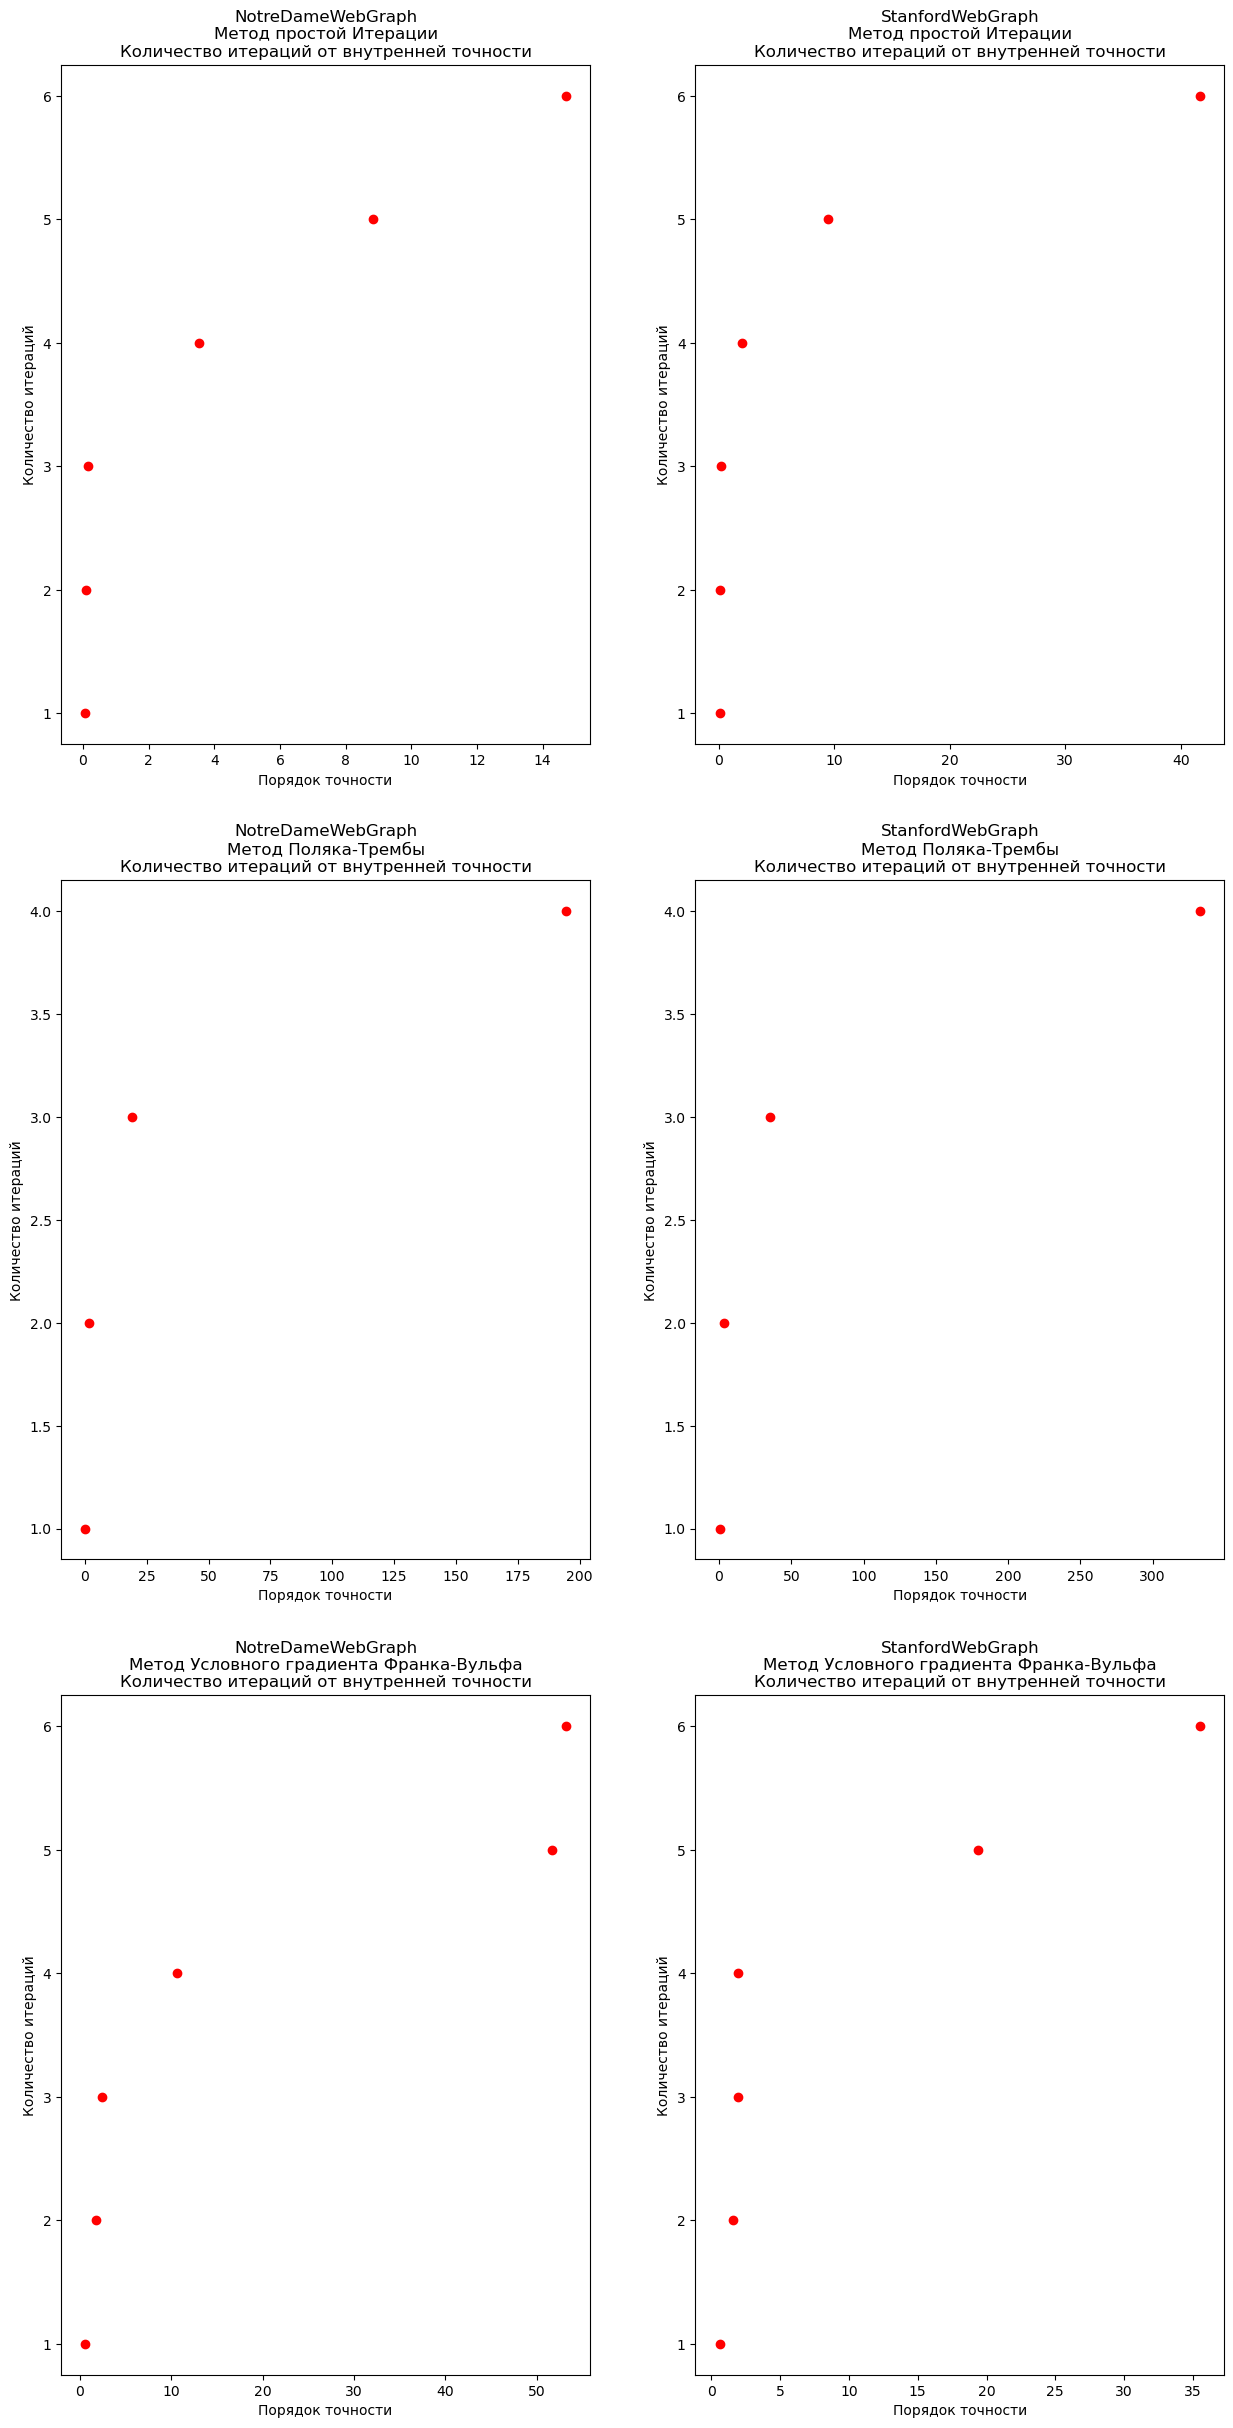

In [78]:
#Точность от времени
fig, axes = plt.subplots(3, 2, figsize = (15,30))

axes[0][0].set_title("NotreDameWebGraph\nМетод простой Итерации\nКоличество итераций от внутренней точности")
axes[1][0].set_title("NotreDameWebGraph\nМетод Поляка-Трембы\nКоличество итераций от внутренней точности")
axes[2][0].set_title("NotreDameWebGraph\nМетод Условного градиента Франка-Вульфа\nКоличество итераций от внутренней точности")

axes[0][1].set_title("StanfordWebGraph\nМетод простой Итерации\nКоличество итераций от внутренней точности")
axes[1][1].set_title("StanfordWebGraph\nМетод Поляка-Трембы\nКоличество итераций от внутренней точности")
axes[2][1].set_title("StanfordWebGraph\nМетод Условного градиента Франка-Вульфа\nКоличество итераций от внутренней точности")


[axes[i][j].set_xlabel("Порядок точности") for i in range(3) for j in range(2)]
[axes[i][j].set_ylabel("Количество итераций") for i in range(3) for j in range(2)]

axes[0][0].plot(MSI_resultsND["Exec_time"], MSI_resultsND["Accuracy"], "ro")
axes[1][0].plot(PT_resultsND["Exec_time"], PT_resultsND["Accuracy"], "ro")
axes[2][0].plot(FW_resultsND["Exec_time"], FW_resultsND["Accuracy"], "ro")

axes[0][1].plot(MSI_results_Stanf["Exec_time"], MSI_results_Stanf["Accuracy"], "ro")
axes[1][1].plot(PT_results_Stanf["Exec_time"], PT_results_Stanf["Accuracy"], "ro")
axes[2][1].plot(FW_results_Stanf["Exec_time"], FW_results_Stanf["Accuracy"], "ro")

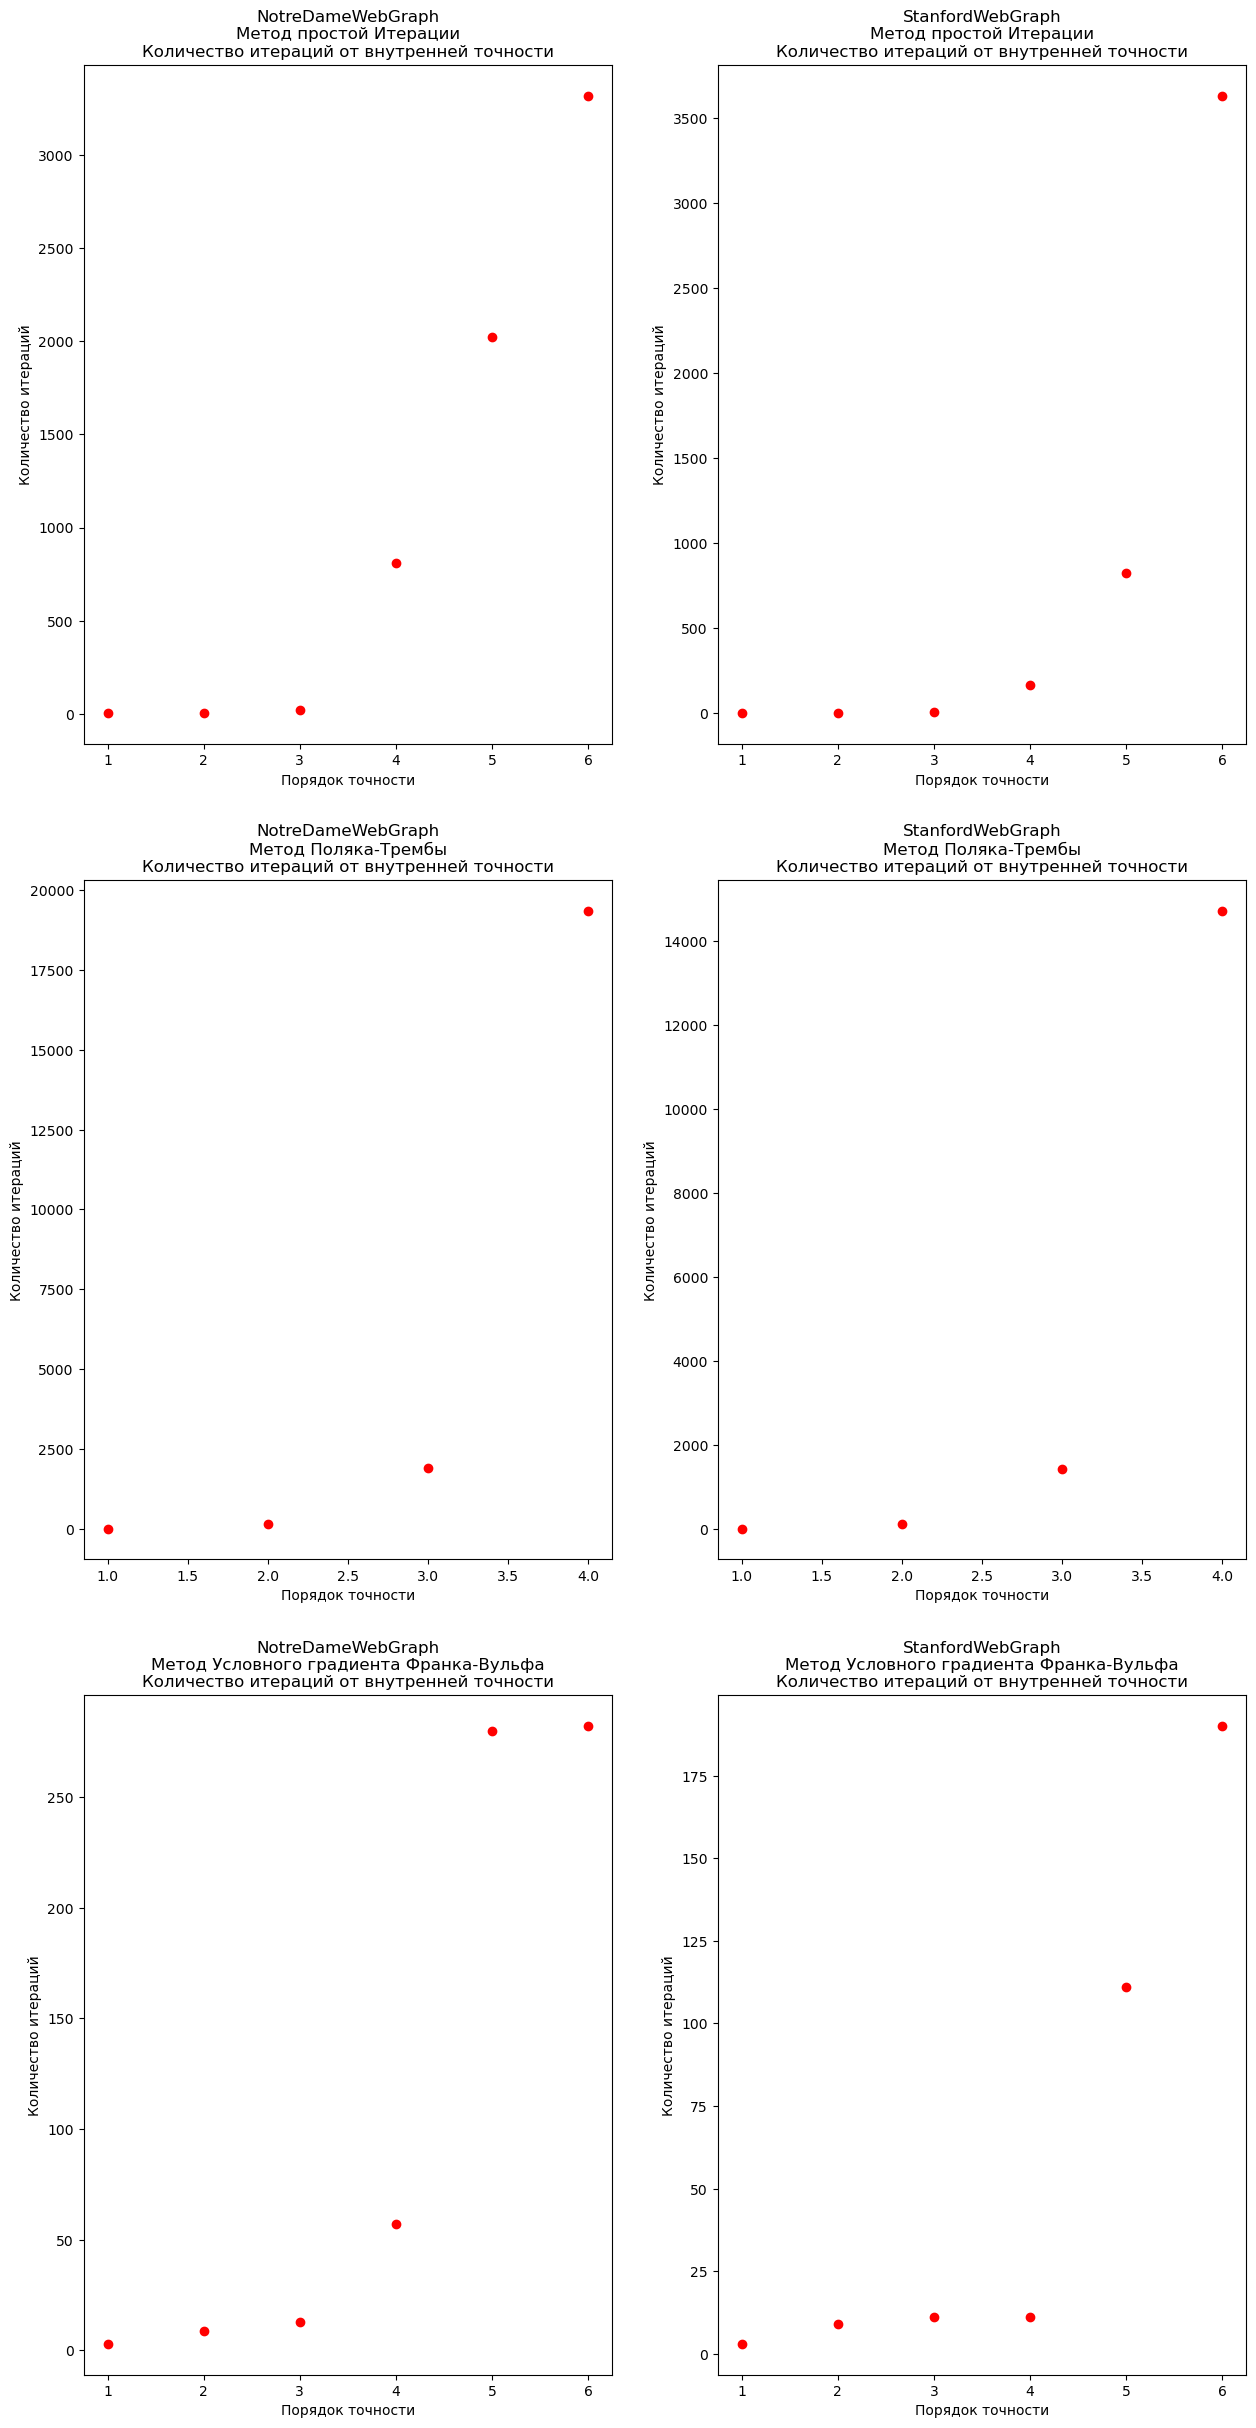

In [29]:
#Количество итераций от точности
fig, axes = plt.subplots(3, 2, figsize = (15,30))

axes[0][0].set_title("NotreDameWebGraph\nМетод простой Итерации\nКоличество итераций от внутренней точности")
axes[1][0].set_title("NotreDameWebGraph\nМетод Поляка-Трембы\nКоличество итераций от внутренней точности")
axes[2][0].set_title("NotreDameWebGraph\nМетод Условного градиента Франка-Вульфа\nКоличество итераций от внутренней точности")

axes[0][1].set_title("StanfordWebGraph\nМетод простой Итерации\nКоличество итераций от внутренней точности")
axes[1][1].set_title("StanfordWebGraph\nМетод Поляка-Трембы\nКоличество итераций от внутренней точности")
axes[2][1].set_title("StanfordWebGraph\nМетод Условного градиента Франка-Вульфа\nКоличество итераций от внутренней точности")


[axes[i][j].set_xlabel("Порядок точности") for i in range(3) for j in range(2)]
[axes[i][j].set_ylabel("Количество итераций") for i in range(3) for j in range(2)]

axes[0][0].plot(MSI_resultsND["Accuracy"], MSI_resultsND["Iterations"], "ro")
axes[1][0].plot(PT_resultsND["Accuracy"], PT_resultsND["Iterations"], "ro")
axes[2][0].plot(FW_resultsND["Accuracy"], FW_resultsND["Iterations"], "ro")

axes[0][1].plot(MSI_results_Stanf["Accuracy"], MSI_results_Stanf["Iterations"], "ro")
axes[1][1].plot(PT_results_Stanf["Accuracy"], PT_results_Stanf["Iterations"], "ro")
axes[2][1].plot(FW_results_Stanf["Accuracy"], FW_results_Stanf["Iterations"], "ro")

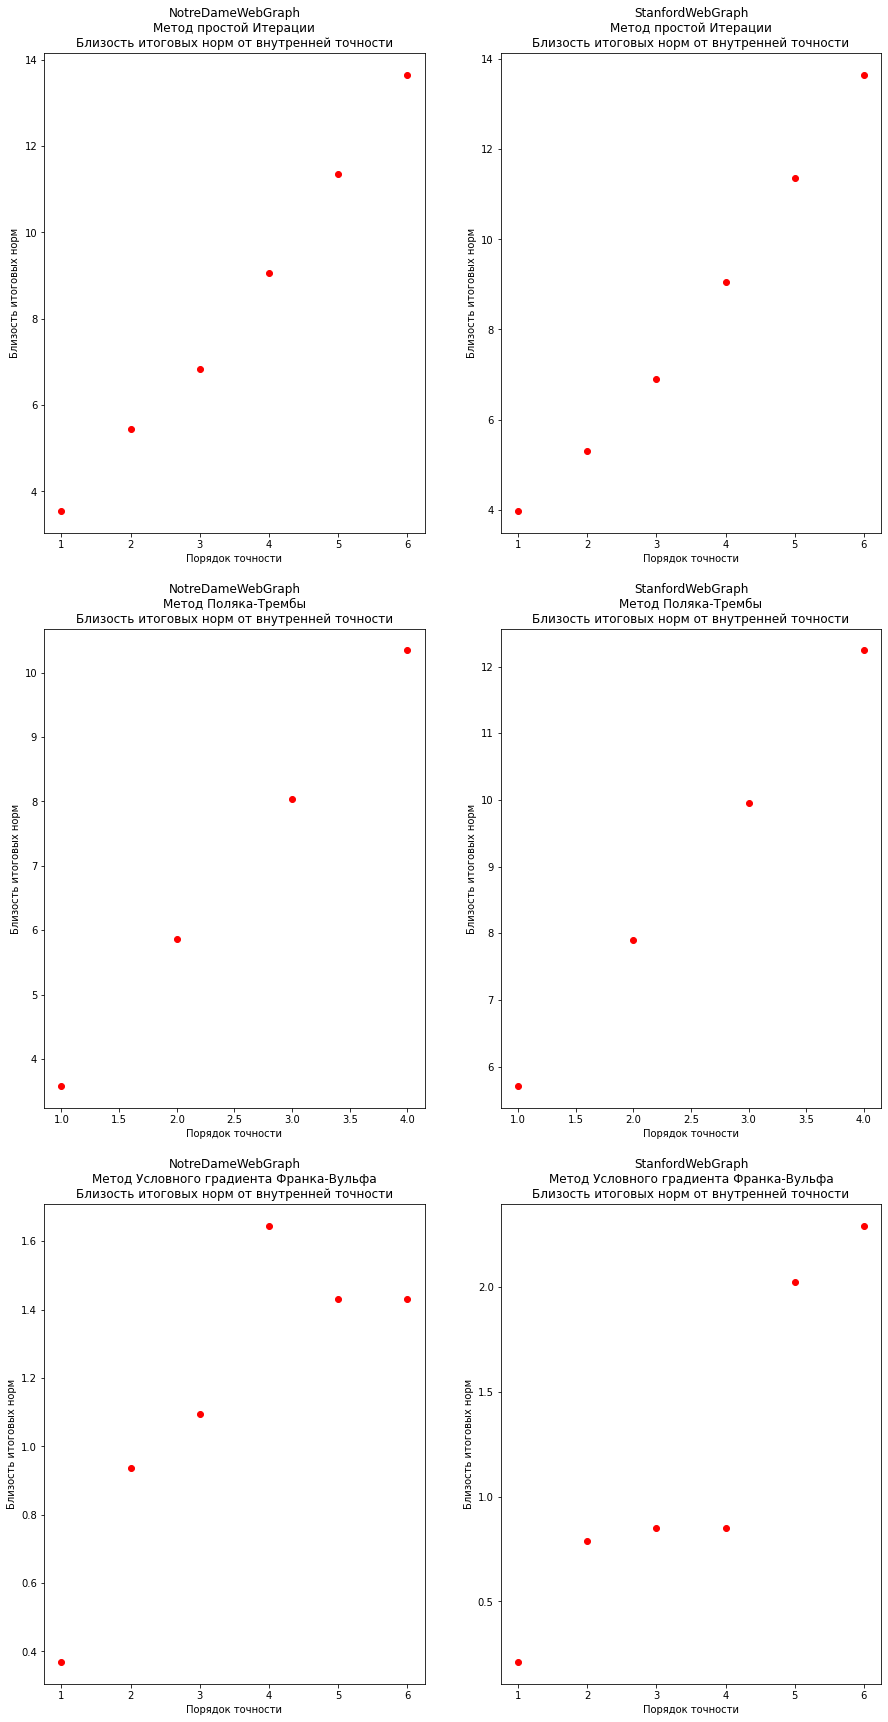

In [12]:
#Близость итоговых норм от внутренней точности
fig, axes = plt.subplots(3, 2, figsize = (15,30))

axes[0][0].set_title("NotreDameWebGraph\nМетод простой Итерации\nБлизость итоговых норм от внутренней точности")
axes[1][0].set_title("NotreDameWebGraph\nМетод Поляка-Трембы\nБлизость итоговых норм от внутренней точности")
axes[2][0].set_title("NotreDameWebGraph\nМетод Условного градиента Франка-Вульфа\nБлизость итоговых норм от внутренней точности")

axes[0][1].set_title("StanfordWebGraph\nМетод простой Итерации\nБлизость итоговых норм от внутренней точности")
axes[1][1].set_title("StanfordWebGraph\nМетод Поляка-Трембы\nБлизость итоговых норм от внутренней точности")
axes[2][1].set_title("StanfordWebGraph\nМетод Условного градиента Франка-Вульфа\nБлизость итоговых норм от внутренней точности")


[axes[i][j].set_xlabel("Порядок точности") for i in range(3) for j in range(2)]
[axes[i][j].set_ylabel("Близость итоговых норм") for i in range(3) for j in range(2)]

axes[0][0].plot(MSI_resultsND["Accuracy"], [np.log(1/i) for i in MSI_resultsND["Norm_diff"]], "ro")
axes[1][0].plot(PT_resultsND["Accuracy"], [np.log(1/i) for i in PT_resultsND["Norm_diff"]], "ro")
axes[2][0].plot(FW_resultsND["Accuracy"], [np.log(1/i) for i in FW_resultsND["Norm_diff"]], "ro")

axes[0][1].plot(MSI_results_Stanf["Accuracy"], [np.log(1/i) for i in MSI_results_Stanf["Norm_diff"]], "ro")
axes[1][1].plot(PT_results_Stanf["Accuracy"], [np.log(1/i) for i in PT_results_Stanf["Norm_diff"]], "ro")
axes[2][1].plot(FW_results_Stanf["Accuracy"], [np.log(1/i) for i in FW_results_Stanf["Norm_diff"]], "ro")

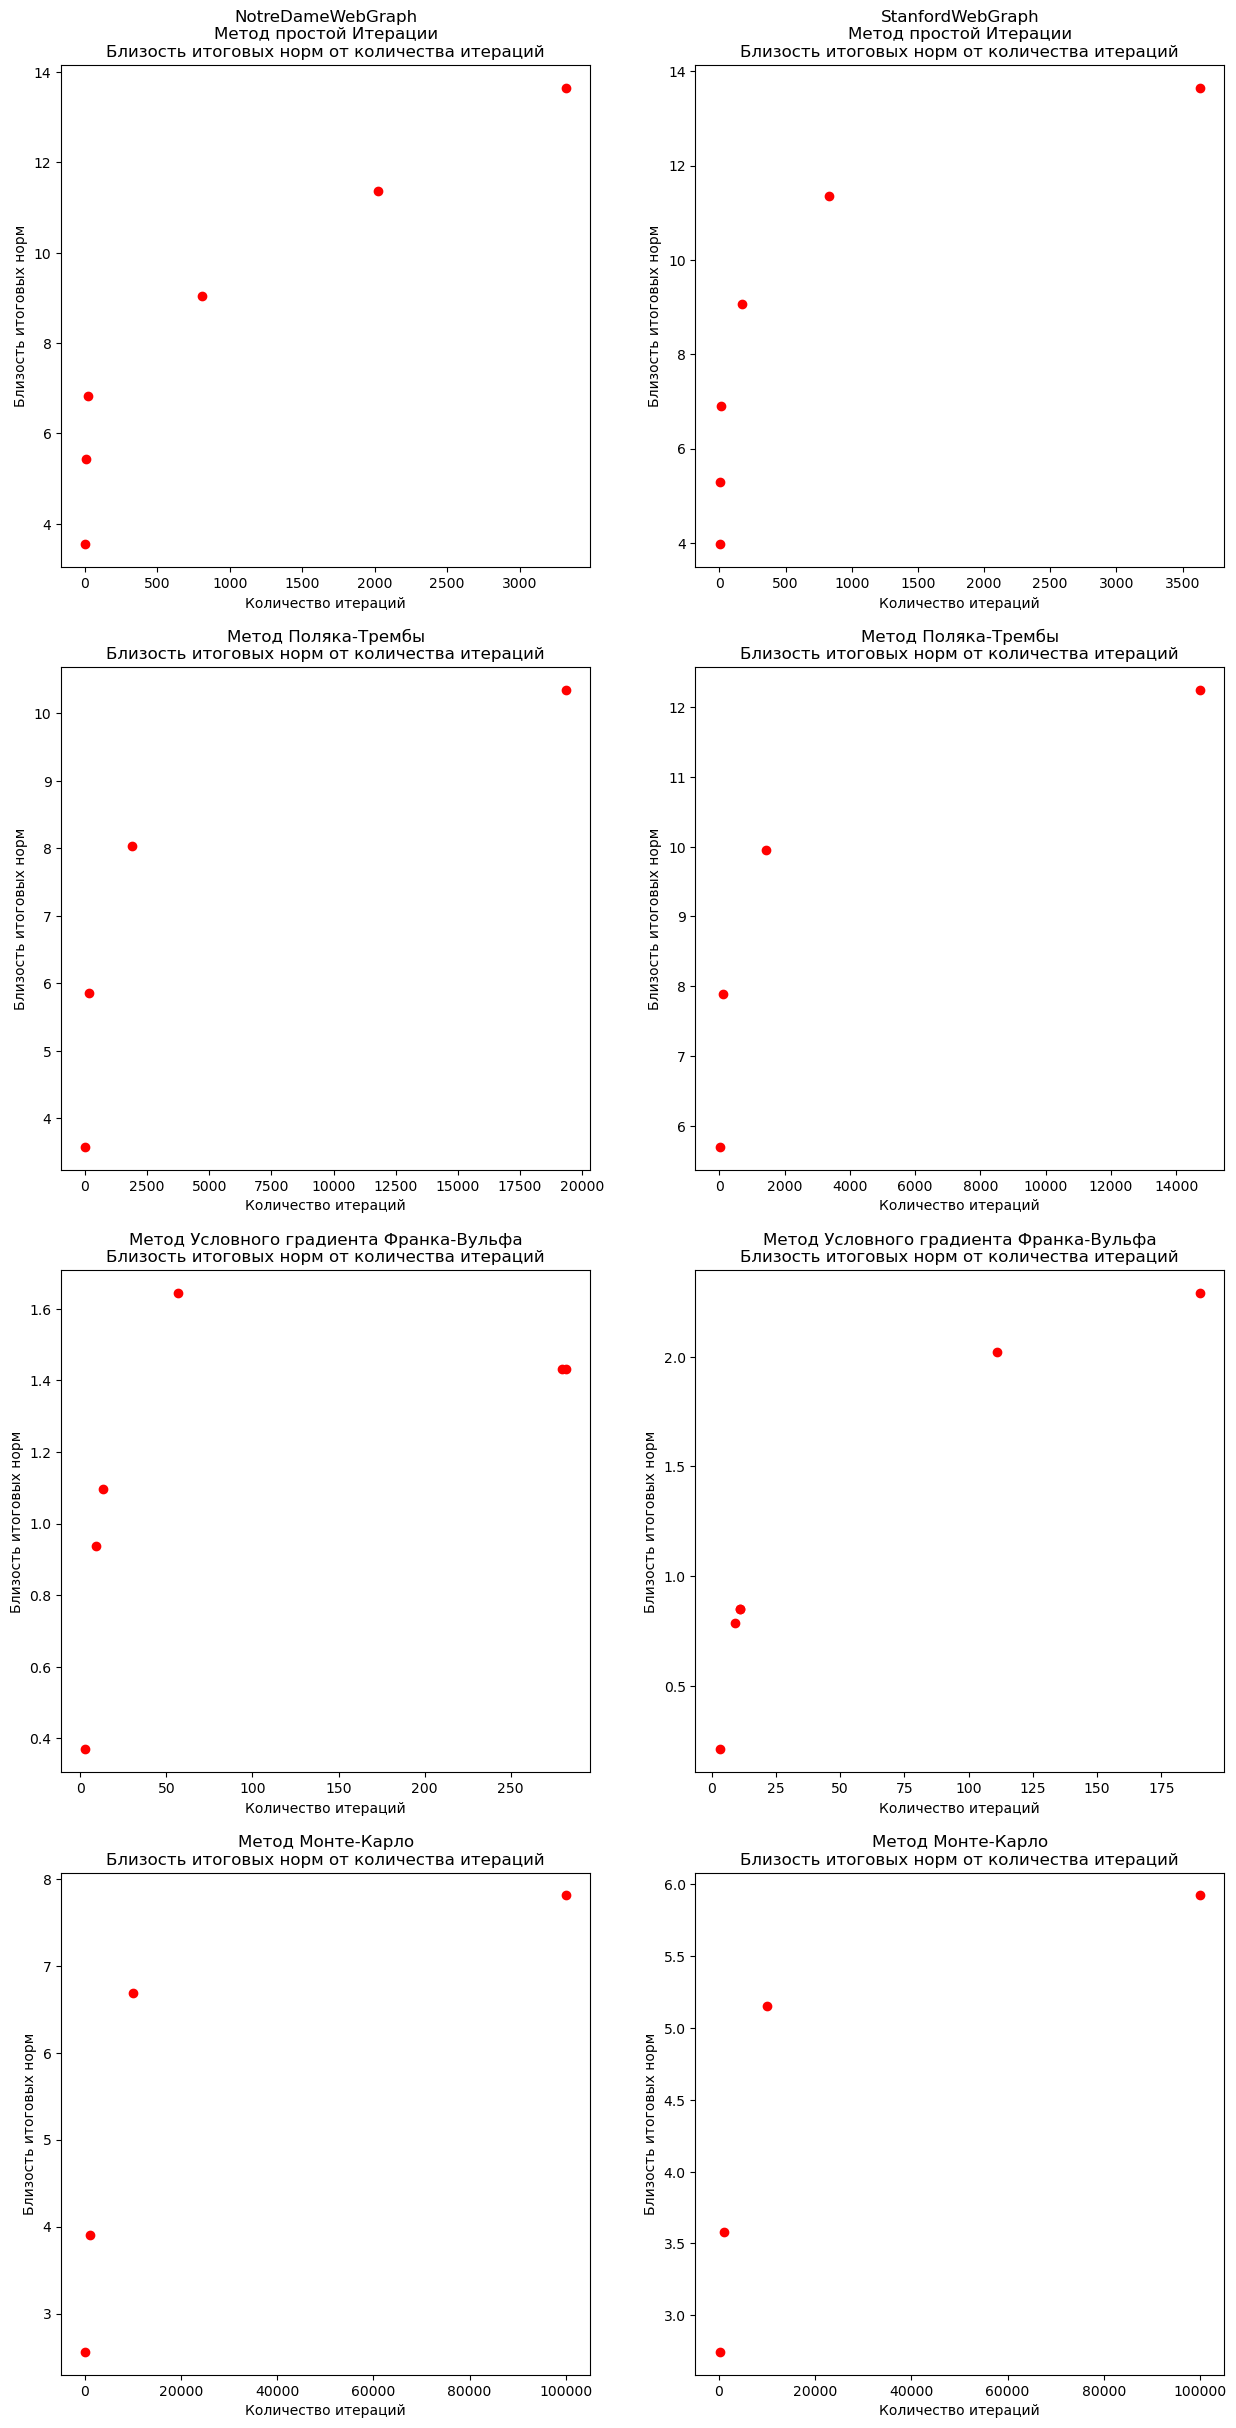

In [32]:
#Точность от количества итераций
#Близость итоговых норм от внутренней точности
fig, axes = plt.subplots(4, 2, figsize = (15,30))

axes[0][0].set_title("NotreDameWebGraph\nМетод простой Итерации\nБлизость итоговых норм от количества итераций")
axes[1][0].set_title("Метод Поляка-Трембы\nБлизость итоговых норм от количества итераций")
axes[2][0].set_title("Метод Условного градиента Франка-Вульфа\nБлизость итоговых норм от количества итераций")
axes[3][0].set_title("Метод Монте-Карло\nБлизость итоговых норм от количества итераций")

axes[0][1].set_title("StanfordWebGraph\nМетод простой Итерации\nБлизость итоговых норм от количества итераций")
axes[1][1].set_title("Метод Поляка-Трембы\nБлизость итоговых норм от количества итераций")
axes[2][1].set_title("Метод Условного градиента Франка-Вульфа\nБлизость итоговых норм от количества итераций")
axes[3][1].set_title("Метод Монте-Карло\nБлизость итоговых норм от количества итераций")


[axes[i][j].set_xlabel("Количество итераций") for i in range(4) for j in range(2)]
[axes[i][j].set_ylabel("Близость итоговых норм") for i in range(4) for j in range(2)]

axes[0][0].plot(MSI_resultsND["Iterations"], [np.log(1/i) for i in MSI_resultsND["Norm_diff"]], "ro")
axes[1][0].plot(PT_resultsND["Iterations"], [np.log(1/i) for i in PT_resultsND["Norm_diff"]], "ro")
axes[2][0].plot(FW_resultsND["Iterations"], [np.log(1/i) for i in FW_resultsND["Norm_diff"]], "ro")
axes[3][0].plot(MC_resultsND["Iterations"], [np.log(1/i) for i in MC_resultsND["Norm_diff"]], "ro")

axes[0][1].plot(MSI_results_Stanf["Iterations"], [np.log(1/i) for i in MSI_results_Stanf["Norm_diff"]], "ro")
axes[1][1].plot(PT_results_Stanf["Iterations"], [np.log(1/i) for i in PT_results_Stanf["Norm_diff"]], "ro")
axes[2][1].plot(FW_results_Stanf["Iterations"], [np.log(1/i) for i in FW_results_Stanf["Norm_diff"]], "ro")
axes[3][1].plot(MC_results_Stanf["Iterations"], [np.log(1/i) for i in MC_results_Stanf["Norm_diff"]], "ro")

In [30]:
print(MC_results_Stanf)
print(MC_resultsND)

{'Iterations': [100, 1000, 10000, 100000], 'Accuracy': [], 'Norm_diff': [0.06418807284575673, 0.02781441613508812, 0.00578230058021891, 0.0026807642184406484]}
{'Iterations': [100, 1000, 10000, 100000], 'Accuracy': [], 'Norm_diff': [0.07740441451750277, 0.020128286385136866, 0.0012504815986933476, 0.0004065563270124178]}
